<a href="https://colab.research.google.com/github/wolframalexa/FrequentistML/blob/master/random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Random forests project

# Read sections 15.1 - 15.3, select a dataset and perform a classification or regression on the dataset 
# using the random forest algorithm in sci-kit learn. Plot the feature importance.

In [30]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.metrics import mean_squared_error as mse

In [9]:
#----------READ DATA

data = 'https://raw.githubusercontent.com/wolframalexa/FrequentistML/master/life_expectancy_data.csv'
dataframe = pd.read_csv(data, sep=',', header='infer')

In [10]:
#----------CLEAN DATA

# Add column to account for intercept 
ones_col = np.ones(len(dataframe))
dataframe.insert(0, "intercept", ones_col, True) 

# Drop rows with missing data
clean_data = dataframe.dropna(axis=0)

# Rename columns
clean_data.columns = ['intercept','country','year','status','life_exp','adult_mort','infant_mort','alcohol','percent_exp','hep_b','measles','bmi','under_five_mort','polio','tot_exp',
                      'diphtheria','hiv_aids','gdp','population','thin_1-19','thin_5-9','income_comp_res','schooling'] 

# Remove rows with invalid data
clean_data = clean_data[clean_data['infant_mort'] <= 1000] 
clean_data = clean_data[clean_data['measles'] <= 1000] 
clean_data = clean_data[clean_data['under_five_mort'] <= 1000]

# Show data information                    
clean_data.describe()

,intercept,year,life_exp,adult_mort,infant_mort,alcohol,percent_exp,hep_b,measles,bmi,under_five_mort,polio,tot_exp,diphtheria,hiv_aids,gdp,population,thin_1-19,thin_5-9,income_comp_res,schooling
count,1357.0,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.00000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1.357000e+03,1357.000000,1357.000000,1357.000000,1357.000000
mean,1.0,2007.941783,70.062122,161.971997,10.862196,4.720442,780.089679,81.265291,91.20339,40.379366,15.097273,85.208548,6.104576,85.543110,1.941489,6123.079003,7.627781e+06,4.215623,4.258364,0.641920,12.409506
std,0.0,4.041488,8.690290,123.624297,25.177559,4.054261,1883.611933,24.863380,193.88610,19.534123,36.859127,21.512464,2.279412,21.154592,6.180984,12197.905019,2.014408e+07,3.728639,3.802764,0.189328,2.745448
min,1.0,2000.000000,44.000000,1.000000,0.000000,0.010000,0.000000,2.000000,0.00000,2.000000,0.000000,3.000000,0.740000,2.000000,0.100000,5.668726,3.400000e+01,0.100000,0.100000,0.000000,4.200000
25%,1.0,2005.000000,65.200000,74.000000,0.000000,1.070000,40.806180,79.000000,0.00000,22.800000,0.000000,84.000000,4.600000,84.000000,0.100000,519.292285,1.557560e+05,1.500000,1.500000,0.542000,10.700000
50%,1.0,2008.000000,72.300000,144.000000,2.000000,4.040000,179.170133,92.000000,3.00000,46.400000,3.000000,94.000000,5.990000,94.000000,0.100000,1839.729450,1.143896e+06,2.700000,2.800000,0.690000,12.500000
75%,1.0,2011.000000,75.400000,219.000000,11.000000,7.440000,579.133164,96.000000,64.00000,56.700000,13.000000,97.000000,7.610000,97.000000,0.600000,5414.634326,5.737723e+06,6.500000,6.500000,0.762000,14.300000
max,1.0,2015.000000,89.000000,723.000000,549.000000,17.870000,18961.348600,99.000000,999.00000,77.100000,879.000000,99.000000,14.390000,99.000000,50.600000,119172.741800,1.986867e+08,19.700000,19.900000,0.936000,20.700000


In [11]:
#----------SEPARATE DATA

# Choose seed
np.random.seed(500)

# Separate training and testing data
train_data, validate_data, test_data = np.split(clean_data.sample(frac=1), [int(.8*len(clean_data)), int(.9*len(clean_data))])

# Separate training inputs and outputs
x_train = train_data.drop(['life_exp','country','status'], axis=1)  
y_train = train_data['life_exp']

# Separate validation inputs and outputs
x_validate = validate_data.drop(['life_exp','country','status'], axis=1)  
y_validate = validate_data['life_exp']

# Separate testing inputs and outputs
x_test = test_data.drop(['life_exp','country','status'], axis=1)
y_test = test_data['life_exp']

# Normalize testing validation and training inputs
x_train = (x_train-x_train.min())/(x_train.max()-x_train.min()) 
x_train.intercept = np.ones(len(x_train))
x_validate = (x_validate-x_validate.min())/(x_validate.max()-x_validate.min()) 
x_validate.intercept = np.ones(len(x_validate))
x_test = (x_test-x_test.min())/(x_test.max()-x_test.min()) 
x_test.intercept = np.ones(len(x_test))

In [25]:
#--------TRAIN MODEL

#n_estimators_lim = 100
min_samples_split_lim = 5
min_samples_leaf_lim = 3


min_score = 100
for split in range(2,min_samples_split_lim):
  for leaf in range(1,min_samples_leaf_lim):
    # make and fit model with these parameters
    rf_model = rf(min_samples_split = split, min_samples_leaf = leaf)
    rf_model.fit(x_train, y_train)
    y_pred = rf_model.predict(x_validate)

    # score model and choose model with lowest error
    score = mse(y_validate, y_pred)
    if score < min_score:
      min_score = score
      best_model = rf_model

print("The best model is the following:\n",best_model)
print("Its score was", min_score)

The best model is the following:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Its score was 6.947167096648373


In [29]:
#--------PREDICT AND REPORT FEATURE IMPORTANCE

y_pred_test = best_model.predict(x_test)
test_score = mse(y_test, y_pred_test)
print("Score on test set:",test_score)
print("Feature importances:\n",list(zip(x_test.columns,rf_model.feature_importances_)))

Score on test set: 2.597972036141512
Feature importances:
 [('intercept', 0.0), ('year', 0.005868226934323356), ('adult_mort', 0.11048142618943643), ('infant_mort', 0.0027785396982092712), ('alcohol', 0.008448974245321796), ('percent_exp', 0.0033671856933163123), ('hep_b', 0.0018278677177858884), ('measles', 0.0042931716885057), ('bmi', 0.011042400114380258), ('under_five_mort', 0.005652760610355372), ('polio', 0.0019771522518048402), ('tot_exp', 0.006198116242103538), ('diphtheria', 0.001168949469442261), ('hiv_aids', 0.4141416795695787), ('gdp', 0.002935858677670207), ('population', 0.0026916636494186985), ('thin_1-19', 0.019212548603762827), ('thin_5-9', 0.009344652100266268), ('income_comp_res', 0.37917173530708814), ('schooling', 0.009397091237230166)]


Compared to the gradient boosted trees, using random forests yields a much lower score on the test set (2.6 vs 7.4). This is because the methods are on different sides of the bias-variance tradeoff - because random forests averages together so many trees, it has low variance but high bias. Meanwhile gradient boosted trees uses the gradient to correct the errors of the previous tree, which reduces bias, but variance remains high. Both methods outperform simple regression, but selection of the method will be determined by the use case.

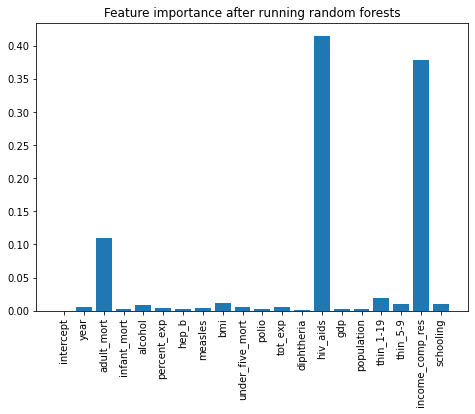

In [35]:
#----------PLOT FEATURE IMPORTANCE

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white') # necessary bc dark mode
ax = fig.add_axes([0,0,1,1])
features = x_test.columns
importances = rf_model.feature_importances_
ax.bar(features, importances)
plt.xticks(rotation=90)
plt.title("Feature importance after running random forests")
plt.show()

HIV/AIDS rate, adult mortality, and income are the most important features by far. This mostly tracks with previous analysis on this dataset (gradient boosted trees and lasso feature selection). However, income and adult mortality are much more important here than using XGBoost, while thinness rate for children 5-9 is slightly less important. This model also eliminates fewer features than the XGBoost model - except for the intercept, none have a coefficient of 0.